# Previsão de Temperaturas Mínimas — Prophet vs LSTM

## 1) Dados (o que são e como foram usados)

* **Fonte:** *Daily Minimum Temperatures in Melbourne* - [Kaggle](https://www.kaggle.com/datasets/paulbrabban/daily-minimum-temperatures-in-melbourne)
* **Granularidade:** diária, ~10 anos (início dos anos 1980 até o fim de 1990).
* **Variáveis originais:**

  * `Date` — data (YYYY-MM-DD)
  * `Temp` — temperatura mínima diária em °C
* **Padronização no notebook:** leitura robusta do CSV (ignorando linhas com formatação ruim), conversão de tipos e renomeação para o formato compatível com Prophet/sktime:

  * `ds` = data (datetime)
  * `y`  = valor (float, °C)
* **Divisão temporal:** últimos **30 dias** como **teste**; todo o restante como **treino** (sem embaralhar).

---

## 2) Modelo com Prophet (como funciona e o que foi configurado)

**Ideia geral.** O Prophet modela a série como soma de **tendência**, **sazonalidades** (semanal/anual) e **ruído**, com pontos de mudança (“changepoints”) na tendência. É rápido, interpretável e aceita regressoras/feriados quando disponíveis.

**Configuração usada no notebook:**

```python
Prophet(
  yearly_seasonality=True,   # sazonalidade anual (muito relevante para clima)
  weekly_seasonality=True,   # pode capturar padrão semanal
  daily_seasonality=False,   # série é diária; sazonalidade intradiária não faz sentido
  interval_width=0.90        # intervalos preditivos de 90%
)
```

**Previsão do horizonte de teste.**

* Foi usado `make_future_dataframe(periods=len(df_test), freq="D")` para criar o “calendarinho” de datas do futuro (mesmo horizonte do teste).
* Após `predict`, selecionamos as previsões (`yhat`) somente nas datas do conjunto de teste.
* **Avaliação:** comparamos `yhat` vs. `y` no teste via **MAPE**.

**Por que assim?**
Temperaturas possuem sazonalidade anual forte, logo `yearly_seasonality=True` é natural. Mantivemos `weekly_seasonality=True` como tentativa leve de capturar padrões semanais; `daily=False` evita um componente que não se aplica a dados de frequência diária.

---

## 3) Modelo com LSTM (o que foi feito e por quê)

**Ideia geral.** Transformamos a série univariada em um problema supervisionado via **janelas deslizantes**: uma janela de `WINDOW=30` dias prevê o próximo dia.

**Pipeline no notebook:**

1. **Escalonamento** somente no treino (`StandardScaler`) para evitar vazamento de informação.
2. **Janelamento:** criamos pares (X, y) onde X é a sequência dos 30 dias anteriores e y é o dia seguinte.
3. **Arquitetura enxuta:**

   ```text
   Input (30x1) → LSTM(64) → Dense(1)
   ```

   Otimizador **Adam**, perda **MSE**, e **EarlyStopping** para estabilizar o treino.
4. **Previsão multi-step (30 dias):** processo **autoregressivo** — a previsão do passo *t* vira entrada para o passo *t+1*, até cobrir todo o horizonte de teste.
5. **Avaliação:** comparamos as previsões invertendo a escala e calculando **MAPE** contra o `y` real no teste.

**Por que assim?**
É um baseline limpo para redes recorrentes, suficiente para comparar contra modelos clássicos sem exagerar em engenharia de features ou arquiteturas profundas.

---

## 4) Resultado da comparação (com múltiplas métricas)

**Horizonte de teste: 30 dias.**
**Resumo:** o **Prophet** manteve **erros médios menores** nas métricas clássicas e também foi melhor nas métricas de “forma” (direção e variação). O **LSTM** mostrou-se mais “reativo” visualmente, mas essa reatividade veio com **mais erro nas oscilações** e **pior acerto de direção**.

**Números (aprox.):**

* **Prophet:** MAPE **13,01%**, SMAPE **13,00%**, MAE **1,90°C**, RMSE **2,59°C**, MASE **0,612**, **Dir(%) 51,7%**, **RMSE_Δ 2,09**
* **LSTM:**   MAPE **13,29%**, SMAPE **14,39%**, MAE **2,07°C**, RMSE **2,91°C**, MASE **0,666**, **Dir(%) 44,8%**, **RMSE_Δ 2,71**

**Leituras-chave:**

* **Erro médio (MAPE/SMAPE/MAE/RMSE/MASE):** o Prophet venceu em todas — previsões **mais estáveis** e com **menor desvio** do valor real no agregado.
* **Direção (Dir%):** Prophet acertou **~51,7%** das viradas (ligeiramente acima do acaso); LSTM ficou em **~44,8%** (abaixo de 50%), indicando **erros frequentes de subida/queda** no dia seguinte.
* **Oscilações (RMSE_Δ):** menor é melhor. O Prophet (**2,09**) reproduziu **melhor o padrão de variações** do que o LSTM (**2,71**), ou seja, o LSTM **“chutou” mais** nos ziguezagues, mesmo parecendo visualmente mais próximo em alguns trechos.

In [2]:
!pip -q install kagglehub pandas

In [8]:
# Importações
import kagglehub, pandas as pd
from pathlib import Path
from prophet import Prophet
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [11]:
# Carregar dataset
path = kagglehub.dataset_download("paulbrabban/daily-minimum-temperatures-in-melbourne")
path = Path(path)
csvs = list(path.glob("*.csv"))
print("Arquivos encontrados:", [p.name for p in csvs])
csv_path = Path(csvs[0])

df = pd.read_csv(
    csv_path,
    engine='python',
    usecols=[0, 1],
    header=0,                 # primeira linha é cabeçalho
    names=['Date', 'Temp'],   # garante nomes consistentes
    on_bad_lines='skip'
)

# 2) Padroniza para Prophet
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Temp'] = pd.to_numeric(df['Temp'], errors='coerce')
df = df.dropna(subset=['Date', 'Temp']).sort_values('Date').reset_index(drop=True)
df = df.rename(columns={'Date': 'ds', 'Temp': 'y'})

# Sanidade
print(df.shape, df.ds.min(), df.ds.max())
print(df.head())

# Split temporal (ex.: últimos 30 dias de teste)
cutoff = df['ds'].max() - pd.Timedelta(days=30)
df_train = df[df['ds'] <= cutoff].copy()
df_test  = df[df['ds']  > cutoff].copy()

m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    interval_width=0.9
)
m.fit(df_train)

# Preparando datas futuras
future = m.make_future_dataframe(periods=len(df_test), freq="D")
fcst = m.predict(future)

pred_prophet = fcst.set_index('ds').loc[df_test['ds'], ['yhat','yhat_lower','yhat_upper']]
test = df_test.set_index('ds')['y']

# Métrica de avaliação
mape_prophet = (abs((test - pred_prophet['yhat'])/test)).mean()*100
print(f"Prophet MAPE: {mape_prophet:.2f}%")
pred_prophet.tail()

Using Colab cache for faster access to the 'daily-minimum-temperatures-in-melbourne' dataset.


DEBUG:cmdstanpy:input tempfile: /tmp/tmpr9o75gqp/ggelh0n3.json


Arquivos encontrados: ['daily-minimum-temperatures-in-me.csv']
(3647, 2) 1981-01-01 00:00:00 1990-12-31 00:00:00
          ds     y
0 1981-01-01  20.7
1 1981-01-02  17.9
2 1981-01-03  18.8
3 1981-01-04  14.6
4 1981-01-05  15.8


DEBUG:cmdstanpy:input tempfile: /tmp/tmpr9o75gqp/qjmoikmd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46105', 'data', 'file=/tmp/tmpr9o75gqp/ggelh0n3.json', 'init=/tmp/tmpr9o75gqp/qjmoikmd.json', 'output', 'file=/tmp/tmpr9o75gqp/prophet_modelctq8h7x6/prophet_model-20251004192654.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:26:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:26:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet MAPE: 13.01%


,yhat,yhat_lower,yhat_upper
ds,,,
1990-12-27,14.573418,10.012671,19.102590
1990-12-28,14.605487,10.174112,18.834494
1990-12-29,14.645449,10.474438,19.033529
1990-12-30,14.602965,10.158740,19.292547
1990-12-31,14.818848,10.452091,19.561593


In [7]:
# Reprodutibilidade
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Série train/test (numpy)
y_train = df_train['y'].astype('float32').values.reshape(-1, 1)
y_test  = df_test['y'].astype('float32').values.reshape(-1, 1)

# Escala (fit só no treino!)
scaler = StandardScaler()
y_train_scaled = scaler.fit_transform(y_train).astype('float32')
y_test_scaled  = scaler.transform(y_test).astype('float32')

# Função para criar janelas supervisionadas X,y (one-step ahead para treino)
def make_windows(series_scaled: np.ndarray, window_size: int):
    X, Y = [], []
    for i in range(len(series_scaled) - window_size):
        X.append(series_scaled[i:i+window_size, 0])
        Y.append(series_scaled[i+window_size, 0])
    X = np.array(X)[:, :, None]  # [samples, timesteps, features=1]
    Y = np.array(Y)[:, None]     # [samples, 1]
    return X, Y

WINDOW = 30  # janela (30 dias)
Xtr, Ytr = make_windows(y_train_scaled, WINDOW)
Xtr.shape, Ytr.shape

# Modelo LSTM simples
model = keras.Sequential([
    keras.layers.Input(shape=(WINDOW, 1)),
    keras.layers.LSTM(64),
    keras.layers.Dense(1)
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss='mse')

es = keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
hist = model.fit(Xtr, Ytr, epochs=200, batch_size=32, verbose=0, callbacks=[es])

# Previsão multi-step H = len(test) AUTORREGRESSIVA (sem olhar o futuro!)
# Começa do último "WINDOW" do treino e vai empilhando as predições
context = y_train_scaled[-WINDOW:].copy().reshape(1, WINDOW, 1)
preds_scaled = []

for _ in range(len(y_test)):
    yhat_scaled = model.predict(context, verbose=0)  # (1,1)
    preds_scaled.append(yhat_scaled[0,0])
    # shift janela: descarta o 1º, adiciona previsão no final
    context = np.concatenate([context[:,1:,:], yhat_scaled.reshape(1,1,1)], axis=1)

preds_scaled = np.array(preds_scaled).reshape(-1,1)
preds_lstm = scaler.inverse_transform(preds_scaled).ravel()

# MAPE LSTM
mape_lstm = (np.abs((df_test['y'].values - preds_lstm) / np.maximum(np.abs(df_test['y'].values), 1e-8))).mean()*100
print(f"LSTM MAPE: {mape_lstm:.2f}%")


LSTM MAPE: 13.29%


             ds  y_true  y_prophet     y_lstm
3642 1990-12-27    14.0  14.573418  15.232192
3643 1990-12-28    13.6  14.605487  13.586274
3644 1990-12-29    13.5  14.645449  12.635429
3645 1990-12-30    15.7  14.602965  12.314203
3646 1990-12-31    13.0  14.818848  12.605808

Resumo MAPE -> Prophet: 13.01% | LSTM: 13.29%


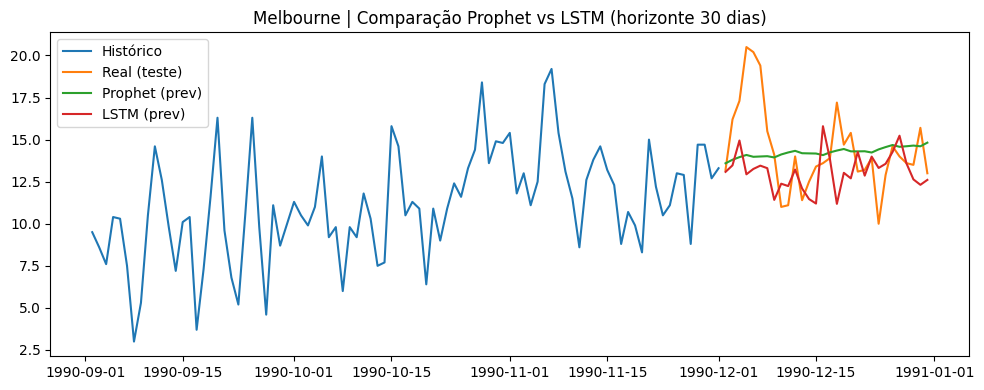

,MAPE,SMAPE,MAE,RMSE,MASE,Dir(%),RMSE_Δ
Prophet,13.01,12.999,1.903,2.589,0.612,51.724,2.093
LSTM,13.29,14.394,2.073,2.910,0.666,44.828,2.706


In [17]:
# Dataframe comparativo dos resultados
res = pd.DataFrame({
    'ds': df_test['ds'],
    'y_true': df_test['y'].values,
    'y_prophet': pred_prophet['yhat'].values,
    'y_lstm': preds_lstm
})

print(res.tail())
print(f"\nResumo MAPE -> Prophet: {mape_prophet:.2f}% | LSTM: {mape_lstm:.2f}%")

# Use índice datetime para fatiar por datas
y_df = df.set_index('ds').sort_index()

plot_start = y_df.index.max() - pd.Timedelta(days=120)
hist_block = y_df.loc[plot_start:cutoff, 'y']

plt.figure(figsize=(10,4))
plt.plot(hist_block.index, hist_block.values, label='Histórico')
plt.plot(res['ds'], res['y_true'], label='Real (teste)')
plt.plot(res['ds'], res['y_prophet'], label='Prophet (prev)')

# Só plota LSTM se existir/preenchido
if np.isfinite(res['y_lstm']).any():
    plt.plot(res['ds'], res['y_lstm'], label='LSTM (prev)')

plt.title('Melbourne | Comparação Prophet vs LSTM (horizonte 30 dias)')
plt.legend()
plt.tight_layout()
plt.show()

# res: ds, y_true, y_prophet, y_lstm (como você já montou)
res = res.set_index('ds').sort_index()
y   = res['y_true'].values
yp  = res['y_prophet'].values
yl  = res['y_lstm'].values

# Série de treino para MASE (usa um ingênuo sazonal como escala)
y_train_arr = df_train.set_index('ds')['y'].values
m_season = 365 if len(y_train_arr) > 365 else 1  # período sazonal (diário ~ anual)

def mape(y, yhat, eps=1e-8):
    mask = np.abs(y) > eps
    return np.mean(np.abs((yhat[mask]-y[mask]) / y[mask]))*100

def smape(y, yhat, eps=1e-8):
    return np.mean(np.abs(yhat-y) / (np.abs(yhat)+np.abs(y)+eps) * 2)*100

def mae(y, yhat):
    return np.mean(np.abs(yhat-y))

def rmse(y, yhat):
    return np.sqrt(np.mean((yhat-y)**2))

def mase(y_train, y_test, yhat, m):
    if len(y_train) <= m:
        return np.nan
    scale = np.mean(np.abs(y_train[m:] - y_train[:-m]))
    return mae(y_test, yhat) / (scale + 1e-8)

# “Reatividade”: acerto de direção e erro nas diferenças (quem segue melhor os ziguezagues?)
def directional_accuracy(y, yhat):
    dy, dhat = np.sign(np.diff(y)), np.sign(np.diff(yhat))
    return (dy == dhat).mean()*100

def rmse_diff(y, yhat):
    return np.sqrt(np.mean((np.diff(yhat) - np.diff(y))**2))

def resumo(nome, yhat):
    return {
        "MAPE": mape(y, yhat),
        "SMAPE": smape(y, yhat),
        "MAE": mae(y, yhat),
        "RMSE": rmse(y, yhat),
        "MASE": mase(y_train_arr, y, yhat, m_season),
        "Dir(%)": directional_accuracy(y, yhat),
        "RMSE_Δ": rmse_diff(y, yhat),
    }

pd.DataFrame([resumo("Prophet", yp), resumo("LSTM", yl)], index=["Prophet","LSTM"]).round(3)